In [6]:
import numpy as np
import pandas as pd

from traffic.core import Traffic
from matplotlib import pyplot as plt
from functions.data_filtering import complete_flight_filter
from functions.data_processing import get_takeoff_and_landing_directions
from functions.data_loading import get_filtered_data_range
from datetime import datetime

In [7]:
origin = "bergen"
destination = "oslo"
filtered_flights: Traffic = get_filtered_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), complete_flight_filter(origin, destination))

In [8]:
filtered_flights

,,count
icao24,callsign,
47875a,NOZ605,30260
478dd9,AKK2,29821
47875c,NOZ601,24104
47a05e,NOZ605,23048
4ac958,SAS252,22801
4ac9ec,SAS238,22763
4acaa3,SAS78A,21955
47875a,NOZ601,21791
47a31a,NOZ605,20963


In [9]:
len(filtered_flights)

3219

In [10]:
directions = list(get_takeoff_and_landing_directions(filtered_flights))
start = [start for start, _ in directions]
end = [end for _, end in directions] 

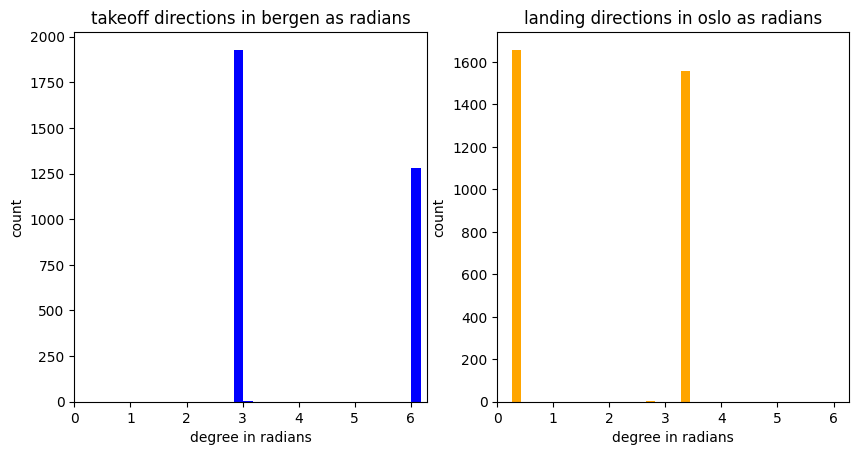

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(start, bins=20, color="blue")
ax[0].set_xlim([0, 2*np.pi])
ax[0].set_title(f"takeoff directions in {origin} as radians")
ax[0].set_xlabel('degree in radians')
ax[0].set_ylabel('count')

ax[1].hist(end, bins=20, color="orange")
ax[1].set_xlim([0, 2*np.pi])
ax[1].set_title(f"landing directions in {destination} as radians")
ax[1].set_xlabel('degree in radians')
ax[1].set_ylabel('count')
fig.set_figwidth(10)
plt.show()

In [12]:
start_x = np.sin(start)
start_y = np.cos(start)
end_x = np.sin(end)
end_y = np.cos(end)

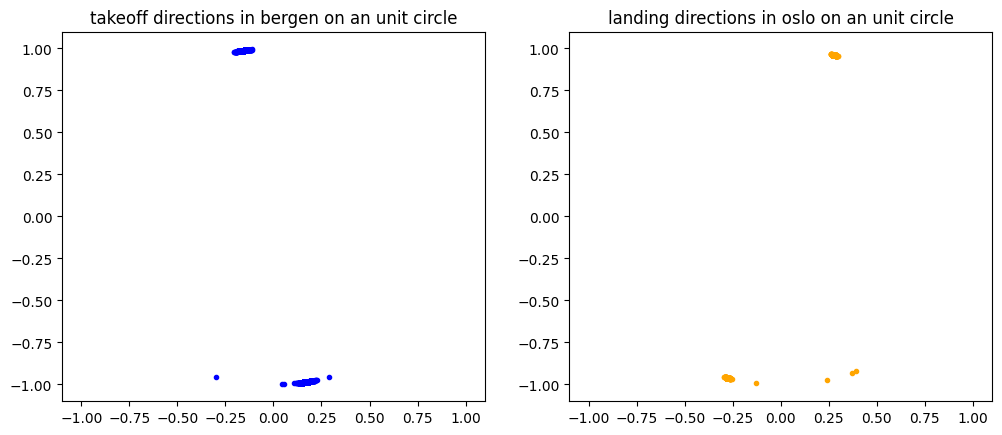

In [13]:
fig, ax = plt.subplots(ncols=2, )
ax: plt.Subplot
ax[0].plot(start_x, start_y, '.', color="blue")
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title(f"takeoff directions in {origin} on an unit circle")

ax[1].plot(end_x, end_y, '.', color="orange")
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title(f"landing directions in {destination} on an unit circle")

fig.set_figwidth(12)
plt.show()

In [14]:
dataset = pd.DataFrame(zip(start_x, start_y, end_x, end_y), columns = ["start_x", "start_y", "end_x", "end_y"])

dataset

,start_x,start_y,end_x,end_y
0,0.203288,-0.979119,-0.278058,-0.960564
1,0.172691,-0.984976,0.266879,0.963730
2,0.172691,-0.984976,-0.279710,-0.960085
3,-0.156721,0.987643,0.271809,0.962351
4,-0.173785,0.984784,0.272543,0.962144
...,...,...,...,...
3214,0.156768,-0.987636,-0.276751,-0.960942
3215,0.171341,-0.985212,-0.276644,-0.960973
3216,0.162680,-0.986679,0.286656,0.958034
3217,0.172555,-0.985000,-0.276644,-0.960973


In [15]:
from sklearn.cluster import DBSCAN

In [16]:
model = DBSCAN()
clustering = model.fit(dataset)

set(clustering.labels_)

{-1, 0, 1, 2, 3}

In [17]:
labels = pd.DataFrame(clustering.labels_, columns=["cluster_label"])
labeled_dataset = pd.concat([dataset, labels], axis=1)

In [18]:
labeled_dataset

,start_x,start_y,end_x,end_y,cluster_label
0,0.203288,-0.979119,-0.278058,-0.960564,0
1,0.172691,-0.984976,0.266879,0.963730,1
2,0.172691,-0.984976,-0.279710,-0.960085,0
3,-0.156721,0.987643,0.271809,0.962351,2
4,-0.173785,0.984784,0.272543,0.962144,2
...,...,...,...,...,...
3214,0.156768,-0.987636,-0.276751,-0.960942,0
3215,0.171341,-0.985212,-0.276644,-0.960973,0
3216,0.162680,-0.986679,0.286656,0.958034,1
3217,0.172555,-0.985000,-0.276644,-0.960973,0


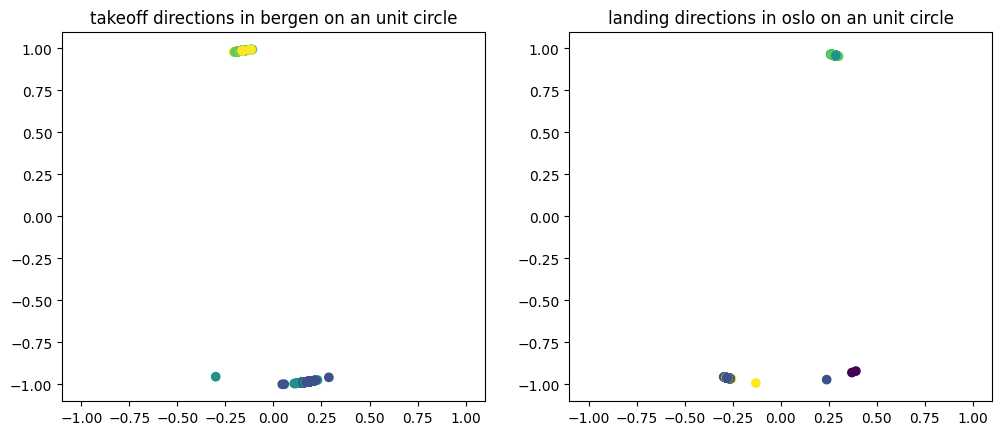

In [19]:
fig, ax = plt.subplots(ncols=2, )
ax: plt.Subplot
ax[0].scatter(labeled_dataset['start_x'], labeled_dataset['start_y'], c=labeled_dataset['cluster_label'])
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title(f"takeoff directions in {origin} on an unit circle")

ax[1].scatter(labeled_dataset['end_x'], labeled_dataset['end_y'], c=labeled_dataset['cluster_label'])
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title(f"landing directions in {destination} on an unit circle")

fig.set_figwidth(12)
plt.show()

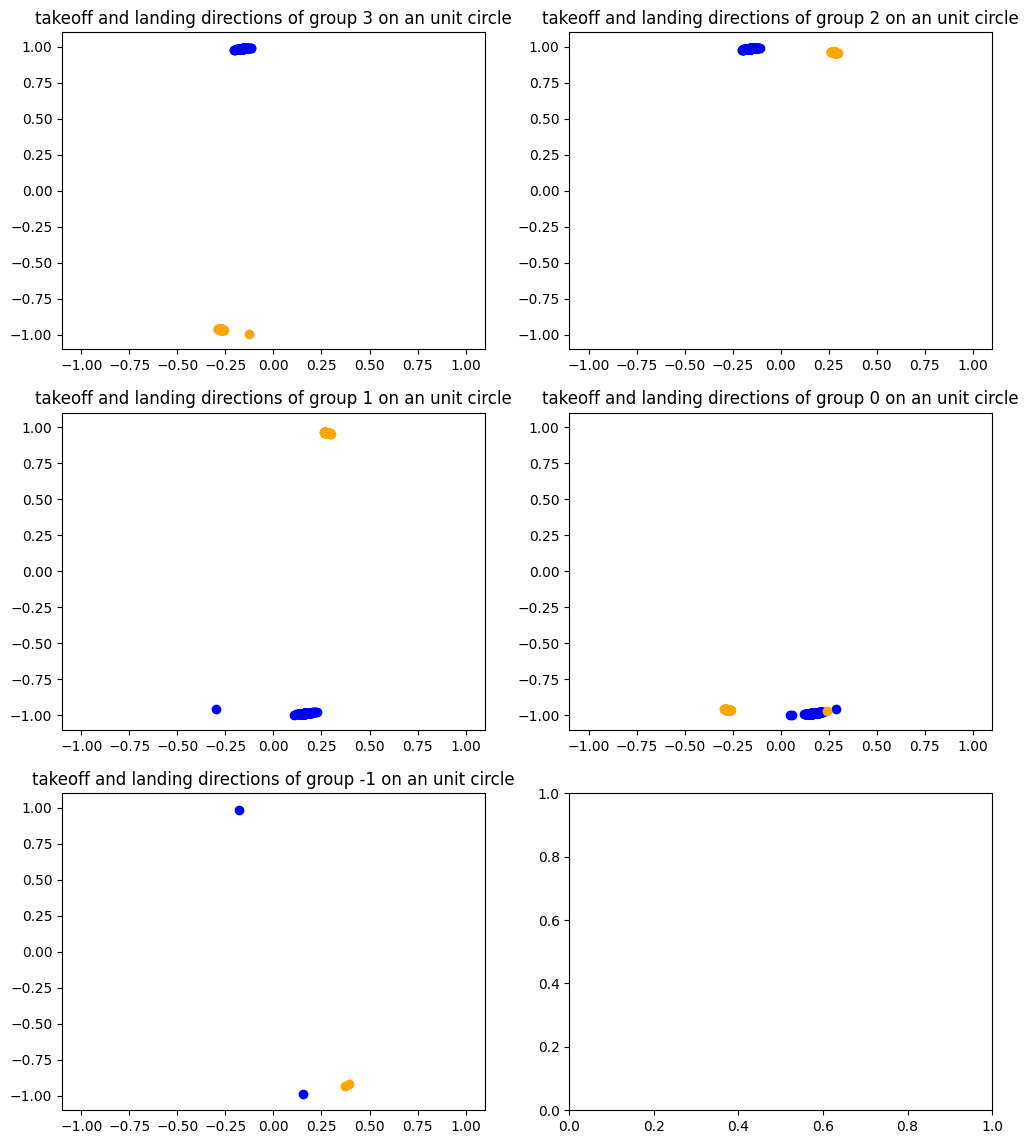

In [36]:
fig, ax = plt.subplots(3, 2)
locs = {3: (0, 0), 2: (0, 1), 1: (1, 0), 0: (1, 1), -1: (2, 0)}
for i in range(3, -2, -1):
    y, x = locs[i]
    filtered_by_label = labeled_dataset.loc[labeled_dataset['cluster_label'] == i]
    
    ax[y, x].scatter(filtered_by_label['start_x'], filtered_by_label['start_y'], c='blue')
    ax[y, x].scatter(filtered_by_label['end_x'], filtered_by_label['end_y'], c='orange')
    ax[y, x].set_xlim([-1.1, 1.1])
    ax[y, x].set_ylim([-1.1, 1.1])
    ax[y, x].set_title(f"takeoff and landing directions of group {i} on an unit circle")
    
    fig.set_figwidth(12)
    fig.set_figheight(14)
plt.show()